# Baseline
Here we will examine the TV-L1 baseline and also see how the FlowNet2 performs on US data

In [1]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage
from utils.encoding import labelMatrixOneHot, dice_coeff


from models.pdd_net.pdd_student import OBELISK2d
import warnings
warnings.filterwarnings('ignore')

In [9]:
cv2.optflow.DualTVL1OpticalFlow_create(outerIterations=5, )#flowNet = load_flownet2()

# Load Data

In [10]:
imgs = torch.load('/share/data_ultraschall/nicke_ma/data/train_frames.pth')
segs = torch.load('/share/data_ultraschall/nicke_ma/data/train_segs.pth')

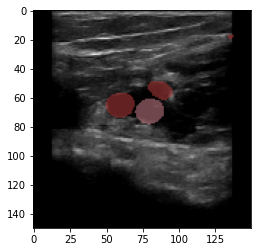

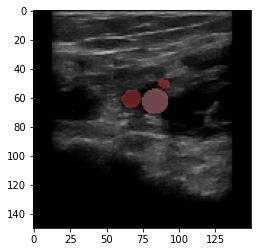

In [60]:
# create a random set for testing
torch.manual_seed(42)
random_set = torch.from_numpy(np.random.choice(np.arange(len(imgs)),size=int(len(imgs)*0.1), replace=False))
random_set

rndidx = random_set[0]
fixed = imgs[rndidx:rndidx+1, 0,:,:]
moving = imgs[rndidx:rndidx+1, 1,:,:]

fixed_seg = segs[rndidx:rndidx+1, 0,:,:]
moving_seg = segs[rndidx:rndidx+1, 1,:,:]

# we need to check the max and min, so we can be sure to get the two labels, if there are some
if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 2:
    fixed_seg = fixed_seg*2
if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 2:
    moving_seg = moving_seg*2

overlay_fixed = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),True)
overlay_moving = overlaySegment(moving.squeeze(),moving_seg.data.squeeze(),False)
plt.imshow(overlay_moving)

In [7]:
dice_coeff(fixed_seg, moving_seg, 3)

tensor([0.8679, 0.8352])

# TV-L1

In [8]:
H,W = fixed_seg.squeeze().shape

In [9]:
# generate and visualize the flow

in1 = fixed.view(H,W,1).numpy().astype(np.float32)
in2 = moving.view(H,W,1).numpy().astype(np.float32)
flow = baseline.calc(in1,in2,None)

torch_flow = torch.from_numpy(flow).unsqueeze(0)
torch_flow.shape

torch.Size([1, 150, 150, 2])

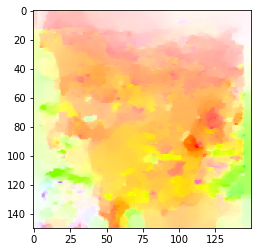

In [10]:
rgb = showFlow(torch_flow.cpu().permute(0,3,1,2).flip(1))
plt.imshow(rgb)

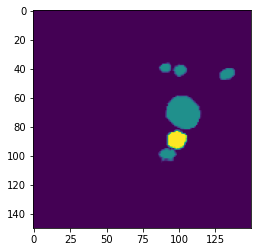

In [11]:
# Warping method found in PWC-Net code
# \models\pwc-net\all_in_one_pwc.py

B, C, H, W = torch_flow.permute(0,3,1,2).size()
# mesh grid
xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
grid = torch.cat((xx, yy), 1).float()

vgrid = grid + torch_flow.permute(0,3,1,2)

# scale grid to [-1,1]
vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

vgrid = vgrid.permute(0, 2, 3, 1)
warped_seg_grid = nn.functional.grid_sample(moving_seg.float().unsqueeze(0), vgrid)
plt.imshow(warped_seg_grid.squeeze())

In [12]:
d0 = dice_coeff(fixed_seg, warped_seg_grid, 3)
d1 = dice_coeff(fixed_seg, moving_seg, 3)
print(d0, d0.mean())
print(d1, d1.mean())

tensor([0.9010, 0.8898]) tensor(0.8954)
tensor([0.8679, 0.8352]) tensor(0.8515)


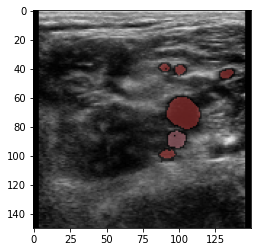

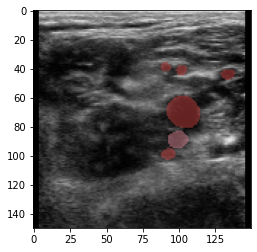

In [13]:
overlayed_seg = overlaySegment(fixed.squeeze(),warped_seg_grid.data.squeeze(),True)
overlayed_seg = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),True)

In [14]:
fixed.shape

torch.Size([1, 150, 150])

# Flownet 2
warping and flow viz testing

In [15]:
flowNet.eval()
# flownet2 and PWC-Net need specific input sizes
teacher_fixed = F.interpolate(fixed.unsqueeze(0), size=(128,128))
teacher_moving = F.interpolate(moving.unsqueeze(0), size=(128,128))
# Generate the teacher flow estimation
flow_in = preprocessing_flownet(teacher_fixed.detach().clone().reshape(128,128,1),teacher_moving.detach().clone().reshape(128,128,1))
teacher_flow = flowNet(flow_in).detach()

In [16]:
teacher_flow = F.interpolate(teacher_flow, size=(H,W), mode='bilinear')
teacher_flow.shape

torch.Size([1, 2, 150, 150])

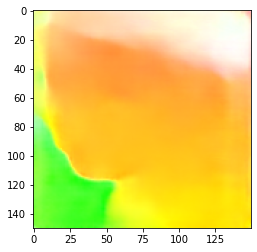

In [17]:
rgb = showFlow(teacher_flow.cpu().flip(1))
plt.imshow(rgb)

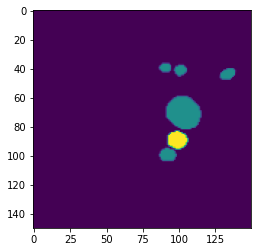

In [18]:
B, C, H, W = teacher_flow.size()
# mesh grid
xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
grid = torch.cat((xx, yy), 1).float()

vgrid = grid + teacher_flow

# scale grid to [-1,1]
vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

vgrid = vgrid.permute(0, 2, 3, 1)
flwonet_warped = nn.functional.grid_sample(moving_seg.float().unsqueeze(0), vgrid)
plt.imshow(flwonet_warped.squeeze())

In [19]:
d0 = dice_coeff(fixed_seg, flwonet_warped, 3)
d1 = dice_coeff(fixed_seg, moving_seg, 3)
print(d0, d0.mean())
print(d1, d1.mean())

tensor([0.9067, 0.9069]) tensor(0.9068)
tensor([0.8679, 0.8352]) tensor(0.8515)


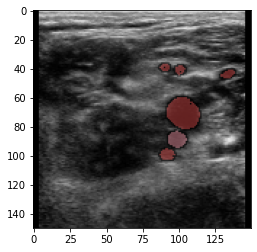

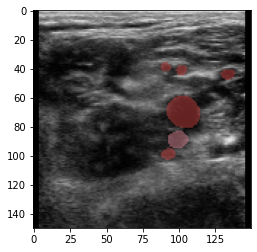

In [20]:
overlayed_seg = overlaySegment(fixed.squeeze(),flwonet_warped.data.squeeze(),True)
overlayed_seg = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),True)

# PDD

somes tests on how to warp pdd-Net segs the best

In [21]:
W,H = (150,150)
o_m = H//2
o_n = W//2
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2)
disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2)

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features

def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

In [22]:
pdd = OBELISK2d(24)
pdd.load_state_dict(torch.load("models/obel_solo_24.pth"))
pdd.eval()
displace_range= 11

In [23]:
with torch.no_grad():
    fixed_feat = pdd(fixed.unsqueeze(0).float())
    moving_feat = pdd(moving.unsqueeze(0).float())

ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//2, W//2)
#upsample field to original resolution
dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')

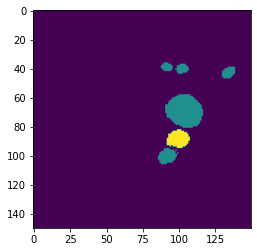

In [41]:
#apply and evaluate transformation

# gridsampling with flow and identity
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False)
warped_student_seg_1 = F.grid_sample(moving_seg.float().unsqueeze(1),identity+dense_flow_fit.flip(1).permute(0,2,3,1),mode='nearest',align_corners=False)


# vs warping method from PWC-Net
B, C, H, W = dense_flow_fit.size()
# mesh grid
xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
grid = torch.cat((xx, yy), 1).float()

vgrid = grid + dense_flow_fit

# scale grid to [-1,1]
vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

vgrid = vgrid.permute(0, 2, 3, 1)
warped_student_seg_2 = nn.functional.grid_sample(moving_seg.float().unsqueeze(0), vgrid)
plt.imshow(warped_student_seg_1.squeeze())

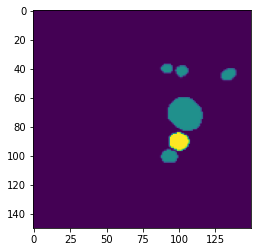

In [42]:
plt.imshow(warped_student_seg_2.squeeze())

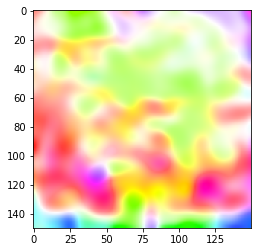

In [43]:
rgb = showFlow(dense_flow_fit.cpu())
plt.imshow(rgb)

In [44]:
d0 = dice_coeff(fixed_seg, warped_student_seg_1, 3)
d1 = dice_coeff(fixed_seg, warped_student_seg_2, 3)
d2 = dice_coeff(fixed_seg, moving_seg, 3)

print(d0, d0.mean())
print(d1, d1.mean())
print(d2, d2.mean())

tensor([0.8707, 0.8997]) tensor(0.8852)
tensor([0.8685, 0.8512]) tensor(0.8599)
tensor([0.8679, 0.8352]) tensor(0.8515)


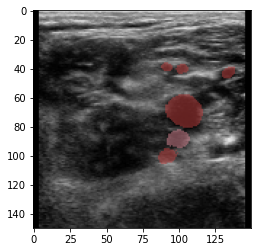

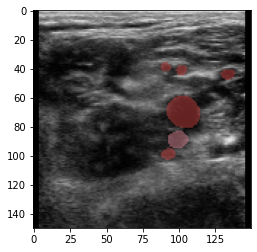

In [45]:
overlayed_seg = overlaySegment(fixed.squeeze(),warped_student_seg_1.data.squeeze(),True)
overlayed_seg = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),True)

# Experiment with FlowNet2 input

In [83]:
def preprocessing_flownet_concat(img_1, img_2):
    """
    Preprocessing function for FlowNet2.

    img1: numpy.ndarray in shape of (H, W, C)
    img2: numpy.ndarray in shape of (H, W, C)

    return: torch.tensor in the	shape of (1, B, C, H, W)
    """
    
    
    img1 = img_1.numpy().copy()
    img2 = img_2.numpy().copy()

    # normalization
    if img1.max() <= 1.0:
        img1 = img1 * 255
    if img2.max() <= 1.0:
        img2 = img2 * 255

    
    # concatenation to generate RGB-Like input
    if img1.shape[2] == 1:
        img1 = np.concatenate([img1,img1,img1], 2)

    if img2.shape[2] == 1:
        img2 = np.concatenate([img2,img2,img2], 2)

    images = [img1, img2]
    images = np.array(images).transpose(3, 0, 1, 2)
    return torch.from_numpy(images.astype(np.float32)).unsqueeze(0)

def preprocessing_flownet_colorMap(img_1, img_2):
    """
    Preprocessing function for FlowNet2.

    img1: torch.Tensor in shape of (H, W, C)
    img2: torch.Tensor in shape of (H, W, C)

    return: torch.tensor in the	shape of (1, B, C, H, W)
    """
    
    
    img1 = img_1.numpy().copy()
    img2 = img_2.numpy().copy()

    if img1.max() <= 1.0:
        img1 = img1 * 255
    if img2.max() <= 1.0:
        img2 = img2 * 255

        
    # generate RGB-like input through colormapping
    img1 = cv2.applyColorMap(img1, cv2.COLORMAP_HSV)
    img2 = cv2.applyColorMap(img2, cv2.COLORMAP_HSV)

    images = [img1, img2]
    images = np.array(images).transpose(3, 0, 1, 2)
    return torch.from_numpy(images.astype(np.float32)).unsqueeze(0)

In [85]:
rndidx = random_set[0]
fixed_orig = imgs[rndidx:rndidx+1, 0,:,:]
moving_orig = imgs[rndidx:rndidx+1, 1,:,:]

fixed_seg = segs[rndidx:rndidx+1, 0,:,:]
moving_seg = segs[rndidx:rndidx+1, 1,:,:]

# we need to check the max and min, so we can be sure to get the two labels, if there are some
if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 2:
    fixed_seg = fixed_seg*2
if len(torch.where(torch.histc(moving_seg) != 0)[0]) == 3 and moving_seg.max() <= 2:
    moving_seg = moving_seg*2

fixed = F.interpolate(fixed_orig.unsqueeze(0), size=(128,128))
moving = F.interpolate(moving_orig.unsqueeze(0), size=(128,128))

fixed.shape

torch.Size([1, 1, 128, 128])

In [86]:
# compate the two RGB-Like images for optical flow estimation
imgs_in_concat = preprocessing_flownet_concat(fixed.view(128,128,1),moving.view(128,128,1))
print(imgs_in_concat.shape)
imgs_in_maped = preprocessing_flownet_concat(fixed.view(128,128,1),moving.view(128,128,1))
print(imgs_in_maped.shape)

torch.Size([1, 3, 2, 128, 128])
torch.Size([1, 3, 2, 128, 128])


In [87]:
flow_concat = flowNet(imgs_in_concat.cuda()).cpu().detach()
flow_map = flowNet(imgs_in_maped.cuda()).cpu().detach()

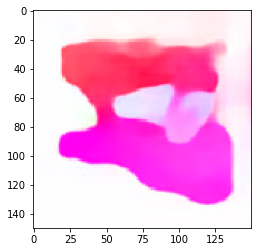

In [88]:
flow_concat = F.interpolate(flow_concat, size=(150,150))
rgb = showFlow(flow_concat.flip(1))
plt.imshow(rgb)

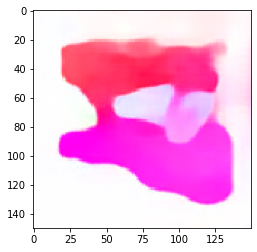

In [89]:
flow_map = F.interpolate(flow_map, size=(150,150))
rgb = showFlow(flow_map.flip(1))
plt.imshow(rgb)

In [90]:
def warp_seg(moving_seg, flow):
    """
    function to warp the segemntation of the teacher and baseline
    
    moving_seg: CxHxW
    flow: size: BxCxHxW
    """
    B, C, H, W = flow.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float().to(flow.device)
    
    vgrid = grid + flow

    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    warped_seg_grid = nn.functional.grid_sample(moving_seg.float().unsqueeze(0), vgrid)
    return warped_seg_grid

In [91]:
concat_seg_warped = warp_seg(moving_seg,flow_concat)
map_seg_warped = warp_seg(moving_seg,flow_map)

In [92]:
concat_seg_warped.shape

torch.Size([1, 1, 150, 150])

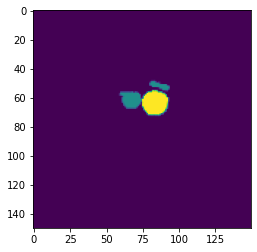

In [93]:
plt.imshow(map_seg_warped.squeeze())

In [94]:
d0 = dice_coeff(fixed_seg.squeeze(), concat_seg_warped.squeeze(),3)
d1 = dice_coeff(fixed_seg.squeeze(), map_seg_warped.squeeze(),3)
d2 = dice_coeff(fixed_seg.squeeze(), moving_seg.squeeze(),3)

In [95]:
d0, d0.mean()

(tensor([0.3282, 0.5114]), tensor(0.4198))

In [96]:
d1, d1.mean()

(tensor([0.3282, 0.5083]), tensor(0.4183))

In [97]:
d2, d2.mean()

(tensor([0.3082, 0.4674]), tensor(0.3878))

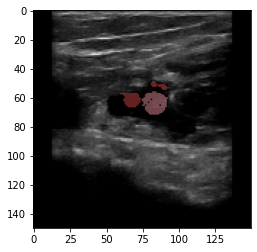

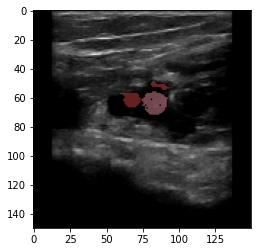

In [82]:
overlayed_seg = overlaySegment(fixed_orig.squeeze(),concat_seg_warped.data.squeeze(),True)
overlayed_seg = overlaySegment(fixed_orig.squeeze(),map_seg_warped.data.squeeze(),True)

# Verdict
color maps do not influence the FlowNet2 performance